In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
import copy
from PIL import Image
import h5py 
from torch.utils.data import Dataset, DataLoader
from matplotlib.pyplot import imshow
import pandas as pd
import random

/home/bhushan/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Helper routines
IS_CUDA = False
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def drawLossPlot(generatorLoss, discriminatorLoss, showPlot = False, savePlot = True, loc = ""):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Vanilla GAN Loss')
    plt.plot(generatorLoss, label='Generator Loss')
    plt.plot(discriminatorLoss, label='Discriminator Loss')
    legend = plt.legend(loc='upper right', shadow=True)
    
    if showPlot:
        plt.show()
    if savePlot:
        plt.savefig(loc+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self):
        self.D_loss = []
        self.G_loss = []

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    

In [3]:
synData = 'data/synHao/'
dataSet1='data/synHao/train_0.h5'
global_batch_size = 50

In [4]:
import os

hfFiles = []
for file in os.listdir(synData):
    hf = h5py.File(synData+file, 'r')
    hfFiles.append(hf)
hf.keys()

[u'data_1', u'data_2', u'label']

In [5]:
from numpy import linalg as LA

In [6]:
# Synthetic Images
#hf = h5py.File(dataSet1, 'r')
#print hf.keys()

# Data Shape 

syn1 = hf['data_1']
syn2 = hf['data_2']
dlabel = hf['label']
synIm1 = np.array(syn1[:,:,:]) #np.swapaxes(np.array(dset[:,:,:]), 1, 3)
synIm2 = np.array(syn2[:,:,:]) #np.swapaxes(np.array(dset2[:,:,:]), 1, 3)
synLabel = np.array(dlabel)

totalSets = len(hfFiles)
print totalSets
for i in range(0, totalSets - 2): # in hfFiles:
    syn1 = hfFiles[i]['data_1']
    syn2 = hfFiles[i]['data_2']
    dlabel = hfFiles[i]['label']
    synIm1 = np.concatenate((synIm1, np.array(syn1[:,:,:]))) #np.swapaxes(np.array(dset[:,:,:]), 1, 3)
    synIm2 = np.concatenate((synIm2, np.array(syn2[:,:,:]))) #np.swapaxes(np.array(dset2[:,:,:]), 1, 3)
    synLabel = np.concatenate((synLabel, np.array(dlabel)))
    print synIm1.shape
    print synIm2.shape
    print synLabel.shape

syn1Val = hfFiles[totalSets-2]['data_1']
syn2Val = hfFiles[totalSets-2]['data_2']
labelVal = hfFiles[totalSets-2]['label']
syn1Val = np.array(syn1Val[:,:,:]) #np.swapaxes(np.array(dset[:,:,:]), 1, 3)
syn2Val = np.array(syn2Val[:,:,:]) #np.swapaxes(np.array(dset2[:,:,:]), 1, 3)
synValLabel = np.array(labelVal)

5
(5000, 64, 64, 3)
(5000, 64, 64, 3)
(5000, 27)
(6638, 64, 64, 3)
(6638, 64, 64, 3)
(6638, 27)
(9138, 64, 64, 3)
(9138, 64, 64, 3)
(9138, 27)


In [98]:
import os
for dirpath, dirs, files in os.walk("./data/synHao"):
    print files

['train_0.h5', 'train_17.h5', 'train_1.h5', 'train_2.h5', 'train_3.h5']


In [7]:
syn1 = hf['data_1']
# print syn1[0]

In [8]:
type(syn1)

h5py._hl.dataset.Dataset

In [9]:
hf = h5py.File(dataSet1, 'r')
syn1 = hf['data_1']

syn1= np.array(syn1[:,:,:])
temp = syn1.astype(int)
print syn1.shape
image = Image.fromarray(syn1[100].astype('int8'), 'RGB')
image.save('file3.png')
image.show()

(2500, 64, 64, 3)


In [10]:
syn1 = np.moveaxis(synIm1, 1, 3)
syn1 = np.moveaxis(syn1, 1, 2)
syn1 = np.moveaxis(syn1, 2, 3)

syn2 = np.moveaxis(synIm2, 1, 3)
syn2 = np.moveaxis(syn2, 1, 2)
syn2 = np.moveaxis(syn2, 2, 3)

syn1Val = np.moveaxis(syn1Val, 1, 3)
syn1Val = np.moveaxis(syn1Val, 1, 2)
syn1Val = np.moveaxis(syn1Val, 2, 3)

syn2Val = np.moveaxis(syn2Val, 1, 3)
syn2Val = np.moveaxis(syn2Val, 1, 2)
syn2Val = np.moveaxis(syn2Val, 2, 3)

In [11]:
print syn1.shape

(9138, 3, 64, 64)


In [12]:
print syn1.max()
syn1N = syn1.astype(float) / 255
print syn1N.max()
syn1B = syn1N * 255
print syn1B.max()
print syn1B.min()

255.0
1.0
255.0
0.0


In [13]:
# print syn3.shape, type(syn3)
# image = Image.fromarray(syn3[10].astype('int8'), 'RGB')
# image.show()

In [14]:
# class MyDataset(Dataset):
#     def __init__(self, numpy_arr, mean, std):
#         self.data = torch.from_numpy(numpy_arr)
#         self.mean = mean
#         self.std = std
#         #normalize here or in __getitem__

#     def __getitem__(self, index):
#         data = self.data[index]
#         #if not already normalized
#         data = data - mean
#         data = data / std
#         return data

#     def __len__(self):
#         return len(self.data)

In [16]:
# mean = np.std(syn1)
# std = np.mean(syn1)

In [17]:
# dataSet = MyDataset(syn1, mean, std)

In [18]:
synImage1 = torch.utils.data.DataLoader(syn1, batch_size = global_batch_size)
synImage2 = torch.utils.data.DataLoader(syn2, batch_size = global_batch_size)
synLabel = torch.utils.data.DataLoader(synLabel, batch_size = global_batch_size)
synVal1 = torch.utils.data.DataLoader(syn1Val, batch_size = global_batch_size)
synVal2 = torch.utils.data.DataLoader(syn2Val, batch_size = global_batch_size)
synValLabel = torch.utils.data.DataLoader(synValLabel, batch_size = global_batch_size)

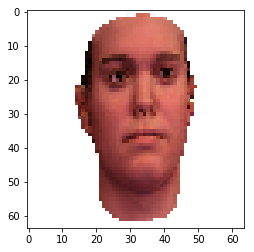

In [19]:
dreal = next(iter(synImage1)).type(torch.ShortTensor)
#print dreal.type
show(dreal[0])

In [20]:
# image = Image.fromarray(syn1[100].astype('uint8'), 'RGB')
# image1 = Image.fromarray(syn2[0].astype('uint8'))
# image.save('file2.png')
# image.show()
# # #image1.show()
# # syn1[100].shape

In [21]:
# Test matlab generated H5 file
hf = h5py.File('../../Light-Estimation/datasets/realImagesSH/data_1.h5', 'r')
print hf.keys()
syn1 = hf['/Image']
lighting = hf['/Lighting']
normal = hf['/Normal']
height = hf['/Height']
reflectance = hf['/Reflectance']
finalLoss = hf['/FinalLoss']
shading = hf['/Shading']

[u'FinalLoss', u'Height', u'Image', u'Lighting', u'Normal', u'Reflectance', u'Shading']


In [22]:
print lighting.shape
print syn1.shape
print normal.shape
print height.shape
print reflectance.shape
print finalLoss.shape
print shading.shape
realImage = torch.utils.data.DataLoader(syn1, batch_size= global_batch_size, shuffle = False)
realSH = torch.utils.data.DataLoader(lighting, batch_size= global_batch_size, shuffle = False)
rNormal = torch.utils.data.DataLoader(normal, batch_size= global_batch_size, shuffle = False)
rHeight = torch.utils.data.DataLoader(height, batch_size= global_batch_size, shuffle = False)
rReflectance = torch.utils.data.DataLoader(reflectance, batch_size= global_batch_size, shuffle = False)
rFinalLoss = torch.utils.data.DataLoader(finalLoss, batch_size= global_batch_size, shuffle = False)
rShading = torch.utils.data.DataLoader(shading, batch_size= global_batch_size, shuffle = False)

(100, 27)
(100, 3, 64, 64)
(100, 3, 64, 64)
(100, 64, 64)
(100, 3, 64, 64)
(100,)
(100, 3, 64, 64)


torch.Size([50, 3, 64, 64])


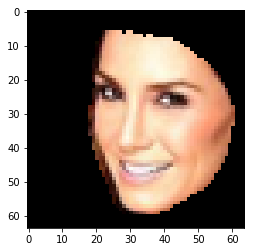

In [23]:
dreal = next(iter(realImage))
print dreal.shape
show(dreal[0])

torch.Size([50, 3, 64, 64])


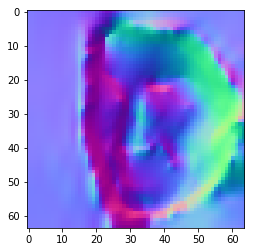

In [24]:
dreal = next(iter(rNormal))
print dreal.shape
show(denorm(dreal[0]))

In [25]:
# Loss function

# Parameters being used by loss functions
MU = 50.0
RHO = 50.0
LAMDA = 0.5
def regressionLossSynthetic(syn1, label):
    return (syn1 - label)**2

def featureLoss(syn1, syn2):
    return (syn1 - syn2)**2

def regressionLoss(syn1, syn2, label):
    rLoss = regressionLossSynthetic(syn1, label) + regressionLossSynthetic(syn2, label)
    fLoss = featureLoss(syn1, syn2)
    loss = RHO * rLoss + LAMDA * fLoss
    return loss.sum()

def GANLoss(vals):
    return vals.mean()

In [26]:
# Resnet == Feature Net
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = conv3x3(3, 16) 
        #, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.lastFC = nn.Linear(128, 128)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #print 'X shape before flatten:', x.shape
        x = x.view(x.size(0), -1)
        #print 'X shape after flatten:', x.shape
        x = self.lastFC(x)
        #x = self.fc(x)

        return x

In [27]:
# Feature Net 
class BaseSimpleFeatureNet(nn.Module):
    def __init__(self):
        super(BaseSimpleFeatureNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 4)
        self.maxpool1 = nn.MaxPool2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.maxpool2 = nn.MaxPool2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.maxpool3 = nn.MaxPool2d(64)
        self.fc1 = nn.Linear(128, 128)
        #self.fc2 = nn.Linear(1024, 128)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        #x = self.maxpool2(x)
        x = F.relu(x)
        #x = self.conv3(x)
        #x = self.maxpool3(x)
        #x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
        #x = F.relu(x)
        #x = self.fc2(x)
        #return x

In [28]:
# Lighting Net
class LightingNet(nn.Module):
    def __init__(self):
        super(LightingNet, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 27) #18)
    
    def forward(self, x):
        #print x.shape
        x = self.fc1(x)
        x = F.relu(x)
        #print x.shape
        x = F.dropout(x)
        x = self.fc2(x)
        return x;

In [29]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 128)
        self.fc1 = nn.Linear(128, 1)
        self.dOut = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.dOut(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.dOut(x)
        x = self.fc1(x)
        x = F.tanh(x)
        return x

In [47]:
featureNet = ResNet(BasicBlock, [2, 2, 2, 2], 27)
#featureNet = BaseSimpleFeatureNet()
lightingNet = LightingNet()
D = Discriminator()
R = ResNet(BasicBlock, [2, 2, 2, 2], 27) #BaseSimpleFeatureNet()

In [36]:
print featureNet

BaseSimpleFeatureNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=(16, 16), stride=(16, 16), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(32, 32), stride=(32, 32), dilation=(1, 1), ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(64, 64), stride=(64, 64), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
)


In [37]:
print lightingNet

LightingNet(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=27, bias=True)
)


In [38]:
#syn1 = torch.FloatTensor(syn1)
#syn2 = torch.FloatTensor(syn2)
#slabel = torch.FloatTensor(slabel)

In [54]:
# Synthetic Net Training
loss = nn.MSELoss()
def train(fNet, lNet, num_epochs = 3):
    fOpt = torch.optim.Adam(fNet.parameters(), lr = 0.0002)
    lOpt = torch.optim.Adam(lNet.parameters(), lr = 0.0002)

    for epoch in range(0, num_epochs):
        tLoss = 0
        for s1, s2, l in zip(synImage1, synImage2, synLabel):
            #print s1.type
            #print 's1', s1.shape
            batchSize = s1.shape[0]
            #print batchSize
            s1 = var(s1).type(torch.FloatTensor)
            s2 = var(s2).type(torch.FloatTensor)
            l = var(l)
            #s1 = s1.transpose(1, 3)
            output = fNet(s1)
            #print 'out:', output.shape
            output = lNet(output)
            output2 = fNet(s2)
            output2 = lNet(output2)
            #print 'L:', output
            #print 'Actual:', l
            Floss = regressionLoss(output, output2, l)
            #Floss = loss(output, l)
            fNet.zero_grad()
            lNet.zero_grad()
            Floss.backward()
            fOpt.step()
            lOpt.step()
            tLoss += Floss
        print 'Epoch:', epoch, 'Loss:', tLoss.data[0]
    # return featureNet

def predict(fNet, lNet, Input):
    val = next(iter(Input)).type(torch.FloatTensor)
    val = var(val)
    
    out = lNet(fNet(val))
    tLabel = var(next(iter(synValLabel)))
    return loss(out, tLabel)

def predictAllSynthetic(fNet, data):
    fsFeatures = []
    i = 0
    for s1 in data:
        s1 = var(s1)
        fsFeatures.append(fNet(s1))
        i += 1
        if i == 10:
            break
    return fsFeatures

In [40]:
train(featureNet, lightingNet, 1)

Epoch: 0 Loss: 56628892.0


In [41]:
err = predict(featureNet, lightingNet, synVal1)
print err.data[0]

0.166457682848


In [42]:
torch.save(featureNet.state_dict(), './featureNet.pkl')
torch.save(lightingNet.state_dict(), './lightingNet.pkl')

In [ ]:
featureNet.load_state_dict(torch.load('./featureNet.pkl'))
lightingNet.load_state_dict(torch.load('./lightingNet.pkl'))

In [43]:
fs = predictAllSynthetic(featureNet, synImage1)

In [ ]:
print len(fs)

In [ ]:
# Training GAN
def trainGAN(lNet, rNet, D, fs, rData, rLabel, numDTrainer= 1, numGTrainer = 1, num_epoch = 5):
    rNet_opt = torch.optim.Adadelta(rNet.parameters(), lr = 0.0002)
    lNet_opt = torch.optim.Adadelta(lNet.parameters(), lr = 0.0002)
    D_opt    = torch.optim.RMSprop(D.parameters(), lr = 0.0002)
    firstCallD = False
    firstCallG = False
    for epoch in range(0, num_epoch):
        GLoss_D = 0.0
        DLoss_D = 0.0
        for rD, rL in zip(rData, rLabel):
            image = var(rD).type(torch.cuda.FloatTensor)
            #print type(image)
            rL = var(rL).type(torch.cuda.FloatTensor)
            batch_size = image.size(0)
            #print batch_size
            # Train the Discriminator
            for k in range(0, numDTrainer):
                # Randomly peack fs to train Discriminator
                rFS = random.randint(0, len(fs)-1)
                #print fs[rFS].shape
                D_real = D(fs[rFS])
                print D_real.size()
                print image.size()
                # Pass real data through generator
                G_fake = rNet(image)
                D_fake = D(G_fake)
                # Loss for Discriminator
                #D_real_loss = lossGAN(D_real, var(torch.ones(batch_size, 1)))
                #D_fake_loss = lossCriterion(D_fake, var(-1 * torch.ones(batch_size, 1)))
                D_real_loss = GANLoss(D_real)
                D_fake_loss = GANLoss(D_fake)
                print 'DLOSS:', D_real_loss.data[0], ' ', D_fake_loss.data[0]
                D_loss = -D_real_loss + D_fake_loss # -ve as we need to maximize
                
                # Backprop Discriminator
                D.zero_grad()
                if firstCallD == True:
                    D_loss.backward(retain_graph=True)
                    firstCallD = False
                else:
                    D_loss.backward(retain_graph = True)
                D_opt.step()
            
            # Train the Generator
            for k in range(0, numGTrainer):
                G_fake = rNet(image)
                D_fake = D(G_fake)
                # Generator Loss
                G_predict = lNet(G_fake)
                #print type(G_predict), type(rL)
                #G_loss = lossCriterion(D_fake, var(torch.ones(batch_size, 1))) + MU * regressionLossSynthetic(G_predict, rLabel)
                G_loss = -GANLoss(D_fake) + MU * regressionLossSynthetic(G_predict, rL).sum()
                #G_loss = MU * regressionLossSynthetic(G_predict, rL).sum()
 
                lNet.zero_grad()
                rNet.zero_grad()
                if firstCallG == True:
                    G_loss.backward(retain_graph=True)
                    firstCallG = False
                else:
                    G_loss.backward(retain_graph = True)
                rNet_opt.step()
                #lNet_opt.step()
            GLoss_D += G_loss.data[0]
            DLoss_D += D_loss.data[0]
        print 'Epoch [{}/{}], Discriminator {}, Generator {}'.format(epoch+1, num_epoch, DLoss_D, GLoss_D)
        if epoch % 100 == 0:
            torch.save(lightingNet.state_dict(), './models/GAN_LNet_'+str(epoch/100)+'.pkl')
            torch.save(D.state_dict(), './models/Discriminator._'+str(epoch/100)+'pkl')
            torch.save(R.state_dict(), './models/Generator_'+str(epoch/100)+'.pkl')


In [ ]:
trainGAN(lightingNet, featureNet, D, fs, realImage, realSH)

In [48]:
# Testing
lightingNet.load_state_dict(torch.load('./GAN_LNet.pkl'))
R.load_state_dict(torch.load('./Generator.pkl'))

torch.Size([50, 3, 64, 64])


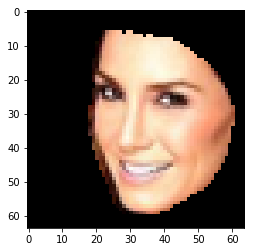

In [65]:
dreal = next(iter(realImage))
print dreal.shape
show(dreal[0])

torch.Size([50, 3, 64, 64])


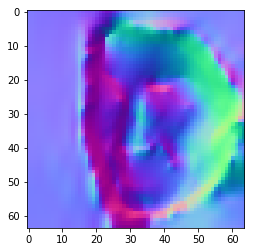

In [93]:
dNormal = next(iter(rNormal))
print dNormal.shape
show(denorm(dNormal[0]))

In [59]:
d = var(dreal).type(torch.FloatTensor)
out = lightingNet(R(d))

In [89]:
print type(dNormal)
dOut = dNormal.numpy()
outSH = out.data.numpy()

<class 'torch.DoubleTensor'>


In [86]:
print out.shape

torch.Size([50, 27])


In [82]:
def writeSHToH5(dNormal, outSH, fileName = 'Normal_SH.h5'):
    hf = h5py.File(fileName, 'w')
    hf.create_dataset('Normal', data=dNormal)
    hf.create_dataset('SH', data=outSH)
    hf.close()

In [91]:
writeSHToH5(dOut, outSH)

In [ ]:
.